# $$Y_i = b_0 + b_1 X_{1i} + b_2 X_{2i} + \epsilon_i$$

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
warnings.filterwarnings("ignore")
%matplotlib inline

In [26]:
df = pd.read_csv("HDI_India.csv")

In [27]:
print ("Total number of rows in dataset = {}".format(df.shape[0]))
print ("Total number of columns in dataset = {}".format(df.shape[1]))

Total number of rows in dataset = 120
Total number of columns in dataset = 4


In [28]:
df.head()

,HDI,GNI_Per_Capita,Life_Exp_At_Birth,Exp_Yr_Of_Schooling
0,0.429,1787,57.9,7.6
1,0.433,1766,58.4,7.7
2,0.440,1825,58.9,7.9
3,0.446,1877,59.3,8.0
4,0.453,1966,59.8,8.1


This dataset contains various indicators(HDI- Human Development Index, GNI_Per_Capita-Proxy for Income Index,Life_Exp_At_Birth-Proxy for Health Index,Exp_Yr_Of_Schooling-Proxy for Education Index) of India,USA,UK and UAE for past 30 years. Data is downloaded from http://hdr.undp.org/en/data. Our objective is to build a regression model to see the causal relationship between HDI and other indexes.

# Some Basic Checks Before Entering Modeling

Check for normality

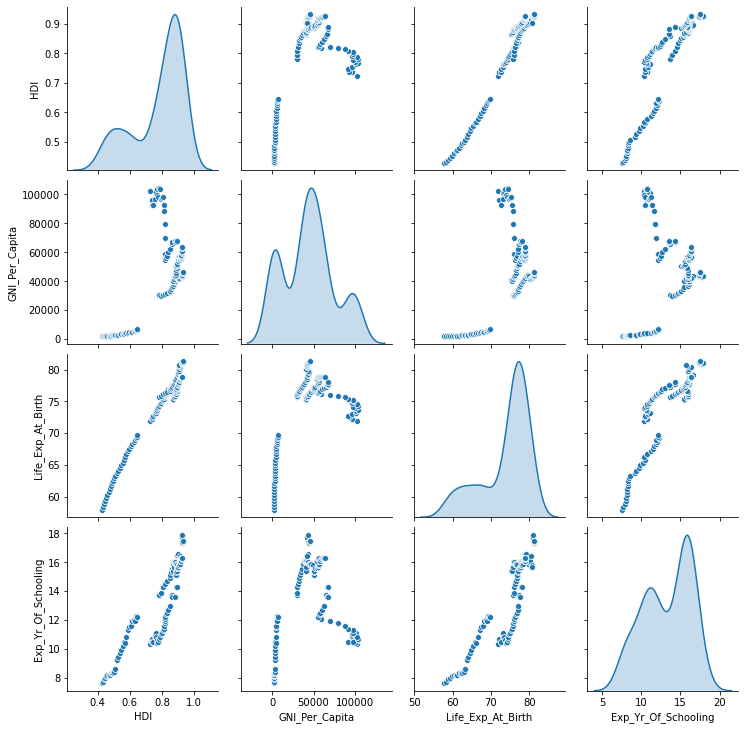

In [29]:
sns.pairplot(df,diag_kind="kde")

Check for missing values

In [30]:
df.isnull().sum()
#if there is any missing value then we can run various imputation method like Mean Imputation, Median Imputation or
#we can drop the records by triggering df.dropna(inplace=True).

HDI                    0
GNI_Per_Capita         0
Life_Exp_At_Birth      0
Exp_Yr_Of_Schooling    0
dtype: int64

## Let's split the Dependent and Independent Variables

In [31]:
X = df.loc[:, df.columns != "HDI"]
y = df.loc[:, "HDI"]

## Check for Multicolinearity

In [32]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X.columns).T

,GNI_Per_Capita,Life_Exp_At_Birth,Exp_Yr_Of_Schooling
vif,3.692822,51.910106,47.13122


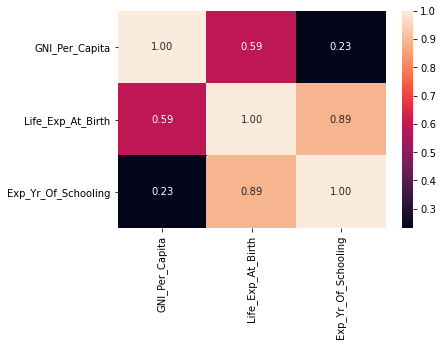

In [33]:
sns.heatmap(X.corr(), annot=True, fmt='.2f')
plt.show()

We can see there is high correlation between Life_Exp_At_Birth and Exp_Yr_Of_Schooling.And it is causing multicollinearity issue. Let's move forward.

## Multiple Linear Regression Model

In [39]:
X_with_constant = sm.add_constant(X)
model1 = sm.OLS(y, X_with_constant)
results = model1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    HDI   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3725.
Date:                Tue, 29 Jun 2021   Prob (F-statistic):          4.14e-115
Time:                        15:35:11   Log-Likelihood:                 329.51
No. Observations:                 120   AIC:                            -651.0
Df Residuals:                     116   BIC:                            -639.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4192    

## Residual Normality

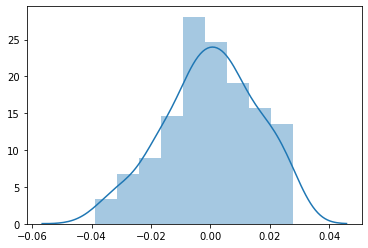

In [41]:
y_pred = results.predict(X_with_constant)
residual = y - y_pred
sns.distplot(residual)

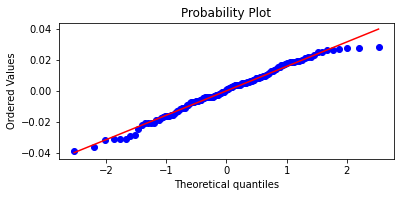

In [42]:
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

In [43]:
np.mean(residual)

5.917627499130163e-14

In [ ]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)

We can see that the mean of the residuals are not zero,violating the assumptions of OLS Regression. Although our model Adjusted-R Square is preety good. This is a classical example of multiciloinearity issue.

## Heteroskedasticity Check

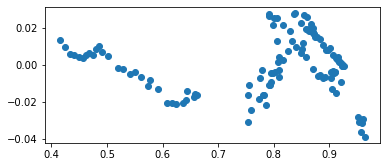

In [44]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)

## Autocorelation Check

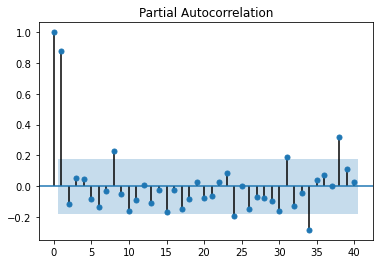

In [59]:
acf = smt.graphics.plot_acf(residual, lags=40 , alpha=0.05)
acf.show()

As we can see that in this model Multicolinearity as well as Autocorilation exists, we can't declare the the model as a BLUE(Best Linear Unbiased Estimator)

# Let's build another model by dropping any of the corelated variable i.e.Life_Exp_At_Birth from our model

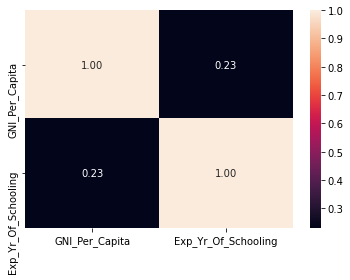

In [48]:
X1 = X.loc[:, X.columns != "Life_Exp_At_Birth"]
sns.heatmap(X1.corr(), annot=True, fmt='.2f')
plt.show()

In [49]:
X1_with_constant = sm.add_constant(X1)
model2 = sm.OLS(y, X1_with_constant)
results_new = model2.fit()
print(results_new.summary())

                            OLS Regression Results                            
Dep. Variable:                    HDI   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2770.
Date:                Tue, 29 Jun 2021   Prob (F-statistic):           2.87e-99
Time:                        15:50:47   Log-Likelihood:                 287.54
No. Observations:                 120   AIC:                            -569.1
Df Residuals:                     117   BIC:                            -560.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1233    

## Residual Normality Check for the New OLS Model

Mean Residual is: -4.001428817919835e-16


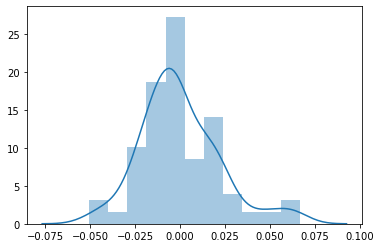

In [54]:
y_pred_new = results_new.predict(X1_with_constant)
residual_new = y - y_pred_new
sns.distplot(residual_new)
print ("Mean Residual is:",np.mean(residual_new))

## Heteroskedasticity Check

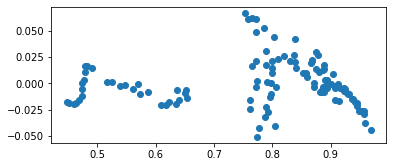

In [55]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred_new, residual_new)

In [66]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(results_new.resid, results_new.model.exog)
bp_test

(9.151457601565625,
 0.010298790675525504,
 4.829655475011012,
 0.009651644794901739)

## Autocorelation Check

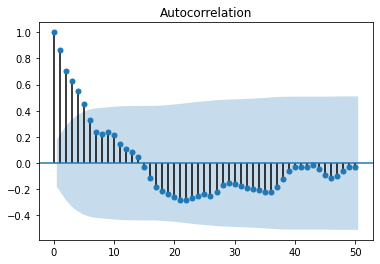

In [63]:
acf = smt.graphics.plot_acf(residual_new, lags=50 , alpha=0.05)
acf.show()